# State Construction Task

In [42]:
from datetime import datetime
import itertools
import io

import numpy as np
import scipy.sparse as sp
import tensorflow as tf

from tqdm import tqdm
import matplotlib.pyplot as plt

generates equidistributed points on unit nd-sphere (see [here](https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf))

In [26]:
def equidistributed_points(dim, dist):
    with np.errstate(divide='ignore'):
        if np.isnan(dist):
            dist = 4 * np.pi
        if dim == 2:
            phis = np.arange(0, 2 * np.pi, dist)
            return np.vstack([np.cos(phis), np.sin(phis)])
        else:
            slices = []
            for phi in np.arange(0, np.pi, dist):
                proj_points = equidistributed_points(dim - 1, dist / np.sin(phi))
                points = np.vstack([np.full((1, proj_points.shape[1]), np.cos(phi)), np.sin(phi) * proj_points])
                slices.append(points)
            return np.hstack(slices)

## solve using Tensorflow

parametric hamiltonian generator with `tf.Variable`

In [27]:
dim = 2

def h_generator():
    def generate_parametric(n, dv_lambda, name):
        params = tf.get_variable(name, dtype='float64', shape=(n, ), initializer=tf.truncated_normal_initializer)
        params = tf.cast(params, 'complex128')
        places = tf.constant(np.stack([dv_lambda(c) for c in range(n)]), dtype='complex128')
        return tf.tensordot(places, params, axes=[0, 0])
    

    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    h = generate_parametric(dim - 1, neardiag, 'neardiag') + generate_parametric(dim, diag, 'diag')
    
    return h

design own solver

In [36]:
def batch_solve_tensorflow(dim, h_generator, source, targets):
    tf.reset_default_graph()
    
    with tf.device('/cpu:0'):
        source = tf.constant(source, dtype='complex128')
        target = tf.placeholder(dtype='complex128', shape=(dim, ))

        h = h_generator()
        gate = tf.linalg.expm(1j * h)
        estimated_target = tf.matmul(gate, tf.expand_dims(source, 1))

        target_dot = tf.matmul(tf.expand_dims(target, 1), estimated_target, adjoint_a=True)
        fidelity = tf.abs(target_dot)
        loss = 1 - fidelity

        summary_op = tf.summary.scalar('fidelity', fidelity)
        optimize_op = tf.train.MomentumOptimizer(momentum=0.8,learning_rate=0.5).minimize(loss)

    fidelities = []
    with tf.Session() as session:
        init_op = tf.global_variables_initializer()
        for t in tqdm(targets):
            session.run(init_op)
            for i in range(5000): # todo, improve stop
                session.run(optimize_op, feed_dict={target: t})
            fidelities.append(session.run(fidelity, feed_dict={target: t}))
    
    return fidelities

In [37]:
angle = 0.3

source = np.array([1] + [0] * (dim - 1))
map_points = equidistributed_points(2 * dim, angle).T
targets = map_points[:, :dim] + 1j * map_points[:, dim:]
targets = list(targets)
fidelities = batch_solve_tensorflow(dim, h_generator, source, targets)





  0%|          | 0/768 [00:00<?, ?it/s]



  0%|          | 1/768 [00:02<34:22,  2.69s/it]



  0%|          | 2/768 [00:06<39:04,  3.06s/it]



  0%|          | 3/768 [00:10<42:50,  3.36s/it]



  1%|          | 4/768 [00:15<46:36,  3.66s/it]



  1%|          | 5/768 [00:18<46:13,  3.64s/it]



  1%|          | 6/768 [00:22<46:07,  3.63s/it]



  1%|          | 7/768 [00:26<48:02,  3.79s/it]



  1%|          | 8/768 [00:30<50:11,  3.96s/it]



  1%|          | 9/768 [00:35<51:35,  4.08s/it]



  1%|▏         | 10/768 [00:39<51:09,  4.05s/it]



  1%|▏         | 11/768 [00:42<49:33,  3.93s/it]



  2%|▏         | 12/768 [00:47<51:05,  4.05s/it]



  2%|▏         | 13/768 [00:51<52:09,  4.14s/it]



  2%|▏         | 14/768 [00:55<51:23,  4.09s/it]



  2%|▏         | 15/768 [00:59<51:54,  4.14s/it]



  2%|▏         | 16/768 [01:03<51:09,  4.08s/it]



  2%|▏         | 17/768 [01:07<50:51,  4.06s/it]



  2%|▏         | 18/768 [01:11<51:48,  4.15s/it]



  2%|▏         | 19/768 [0

 17%|█▋        | 127/768 [09:11<45:55,  4.30s/it]



 17%|█▋        | 128/768 [09:15<44:35,  4.18s/it]



 17%|█▋        | 129/768 [09:19<45:40,  4.29s/it]



 17%|█▋        | 130/768 [09:24<46:28,  4.37s/it]



 17%|█▋        | 131/768 [09:28<46:52,  4.41s/it]



 17%|█▋        | 132/768 [09:32<45:22,  4.28s/it]



 17%|█▋        | 133/768 [09:36<43:48,  4.14s/it]



 17%|█▋        | 134/768 [09:40<44:03,  4.17s/it]



 18%|█▊        | 135/768 [09:44<43:01,  4.08s/it]



 18%|█▊        | 136/768 [09:48<42:10,  4.00s/it]



 18%|█▊        | 137/768 [09:53<45:40,  4.34s/it]



 18%|█▊        | 138/768 [09:57<44:18,  4.22s/it]



 18%|█▊        | 139/768 [10:01<44:25,  4.24s/it]



 18%|█▊        | 140/768 [10:05<44:21,  4.24s/it]



 18%|█▊        | 141/768 [10:10<46:49,  4.48s/it]



 18%|█▊        | 142/768 [10:16<48:27,  4.64s/it]



 19%|█▊        | 143/768 [10:19<46:04,  4.42s/it]



 19%|█▉        | 144/768 [10:24<45:57,  4.42s/it]



 19%|█▉        | 145/768 [10:28<44:50,  4.32s/

 33%|███▎      | 253/768 [18:24<35:53,  4.18s/it]



 33%|███▎      | 254/768 [18:28<34:52,  4.07s/it]



 33%|███▎      | 255/768 [18:32<35:19,  4.13s/it]



 33%|███▎      | 256/768 [18:37<37:35,  4.41s/it]



 33%|███▎      | 257/768 [18:41<36:48,  4.32s/it]



 34%|███▎      | 258/768 [18:45<36:14,  4.26s/it]



 34%|███▎      | 259/768 [18:49<35:50,  4.23s/it]



 34%|███▍      | 260/768 [18:53<34:49,  4.11s/it]



 34%|███▍      | 261/768 [18:57<33:58,  4.02s/it]



 34%|███▍      | 262/768 [19:01<34:19,  4.07s/it]



 34%|███▍      | 263/768 [19:06<35:58,  4.27s/it]



 34%|███▍      | 264/768 [19:10<35:49,  4.26s/it]



 35%|███▍      | 265/768 [19:15<35:38,  4.25s/it]



 35%|███▍      | 266/768 [19:19<36:45,  4.39s/it]



 35%|███▍      | 267/768 [19:24<36:20,  4.35s/it]



 35%|███▍      | 268/768 [19:28<36:08,  4.34s/it]



 35%|███▌      | 269/768 [19:32<34:33,  4.16s/it]



 35%|███▌      | 270/768 [19:36<34:16,  4.13s/it]



 35%|███▌      | 271/768 [19:40<35:41,  4.31s/

 49%|████▉     | 379/768 [27:08<26:52,  4.15s/it]



 49%|████▉     | 380/768 [27:12<26:49,  4.15s/it]



 50%|████▉     | 381/768 [27:16<26:58,  4.18s/it]



 50%|████▉     | 382/768 [27:20<27:03,  4.21s/it]



 50%|████▉     | 383/768 [27:23<25:06,  3.91s/it]



 50%|█████     | 384/768 [27:28<26:28,  4.14s/it]



 50%|█████     | 385/768 [27:31<24:12,  3.79s/it]



 50%|█████     | 386/768 [27:34<22:05,  3.47s/it]



 50%|█████     | 387/768 [27:37<22:04,  3.48s/it]



 51%|█████     | 388/768 [27:42<24:24,  3.85s/it]



 51%|█████     | 389/768 [27:46<24:23,  3.86s/it]



 51%|█████     | 390/768 [27:50<24:31,  3.89s/it]



 51%|█████     | 391/768 [27:54<24:43,  3.94s/it]



 51%|█████     | 392/768 [27:58<24:54,  3.97s/it]



 51%|█████     | 393/768 [28:02<24:40,  3.95s/it]



 51%|█████▏    | 394/768 [28:05<23:38,  3.79s/it]



 51%|█████▏    | 395/768 [28:10<25:19,  4.07s/it]



 52%|█████▏    | 396/768 [28:14<25:23,  4.09s/it]



 52%|█████▏    | 397/768 [28:19<26:47,  4.33s/

 66%|██████▌   | 505/768 [33:43<11:19,  2.58s/it]



 66%|██████▌   | 506/768 [33:46<11:05,  2.54s/it]



 66%|██████▌   | 507/768 [33:48<11:10,  2.57s/it]



 66%|██████▌   | 508/768 [33:51<11:58,  2.76s/it]



 66%|██████▋   | 509/768 [33:54<11:58,  2.77s/it]



 66%|██████▋   | 510/768 [33:57<11:34,  2.69s/it]



 67%|██████▋   | 511/768 [33:59<11:22,  2.66s/it]



 67%|██████▋   | 512/768 [34:02<11:01,  2.58s/it]



 67%|██████▋   | 513/768 [34:04<10:44,  2.53s/it]



 67%|██████▋   | 514/768 [34:07<11:29,  2.72s/it]



 67%|██████▋   | 515/768 [34:10<11:41,  2.77s/it]



 67%|██████▋   | 516/768 [34:13<11:29,  2.74s/it]



 67%|██████▋   | 517/768 [34:15<11:07,  2.66s/it]



 67%|██████▋   | 518/768 [34:18<11:02,  2.65s/it]



 68%|██████▊   | 519/768 [34:21<11:18,  2.73s/it]



 68%|██████▊   | 520/768 [34:24<11:40,  2.82s/it]



 68%|██████▊   | 521/768 [34:27<12:00,  2.92s/it]



 68%|██████▊   | 522/768 [34:30<11:29,  2.80s/it]



 68%|██████▊   | 523/768 [34:33<11:40,  2.86s/

 82%|████████▏ | 631/768 [39:18<05:59,  2.63s/it]



 82%|████████▏ | 632/768 [39:21<05:57,  2.63s/it]



 82%|████████▏ | 633/768 [39:23<05:38,  2.51s/it]



 83%|████████▎ | 634/768 [39:25<05:27,  2.44s/it]



 83%|████████▎ | 635/768 [39:28<05:41,  2.57s/it]



 83%|████████▎ | 636/768 [39:31<05:37,  2.56s/it]



 83%|████████▎ | 637/768 [39:33<05:33,  2.54s/it]



 83%|████████▎ | 638/768 [39:36<05:36,  2.59s/it]



 83%|████████▎ | 639/768 [39:38<05:34,  2.59s/it]



 83%|████████▎ | 640/768 [39:41<05:24,  2.54s/it]



 83%|████████▎ | 641/768 [39:43<05:18,  2.51s/it]



 84%|████████▎ | 642/768 [39:46<05:25,  2.58s/it]



 84%|████████▎ | 643/768 [39:48<05:08,  2.47s/it]



 84%|████████▍ | 644/768 [39:51<05:07,  2.48s/it]



 84%|████████▍ | 645/768 [39:53<05:03,  2.47s/it]



 84%|████████▍ | 646/768 [39:56<04:57,  2.44s/it]



 84%|████████▍ | 647/768 [39:58<04:51,  2.41s/it]



 84%|████████▍ | 648/768 [40:01<05:03,  2.53s/it]



 85%|████████▍ | 649/768 [40:03<04:59,  2.52s/

 99%|█████████▊| 757/768 [44:53<00:29,  2.67s/it]



 99%|█████████▊| 758/768 [44:56<00:25,  2.59s/it]



 99%|█████████▉| 759/768 [44:59<00:24,  2.70s/it]



 99%|█████████▉| 760/768 [45:02<00:21,  2.68s/it]



 99%|█████████▉| 761/768 [45:04<00:18,  2.71s/it]



 99%|█████████▉| 762/768 [45:07<00:16,  2.69s/it]



 99%|█████████▉| 763/768 [45:09<00:12,  2.57s/it]



 99%|█████████▉| 764/768 [45:12<00:10,  2.63s/it]



100%|█████████▉| 765/768 [45:15<00:07,  2.66s/it]



100%|█████████▉| 766/768 [45:17<00:05,  2.60s/it]



100%|█████████▉| 767/768 [45:19<00:02,  2.51s/it]



100%|██████████| 768/768 [45:23<00:00,  2.71s/it]

In [39]:
f_min = min(fidelities)
d = np.cos(angle)
MGF = (np.sqrt(d * f_min) - np.sqrt((1 - d) * (1 - f_min))) ** 2

print('d: ', d)
print('minimum fidelity: ', f_min)
print('average fidelity: ', sum(fidelities) / len(fidelities))
print('MGF: ', MGF)

d:  0.955336489125606
minimum fidelity:  [[0.73739372]]
average fidelity:  [[0.99964463]]
MGF:  [[0.53439097]]


In [70]:
angle = 0.05

source = np.array([1] + [0] * (dim - 1))
targets = list(equidistributed_points(dim, angle).T)
fidelities = batch_solve_tensorflow(dim, h_generator, source, targets)






  0%|          | 0/126 [00:00<?, ?it/s]




  1%|          | 1/126 [00:02<05:12,  2.50s/it]




  2%|▏         | 2/126 [00:04<05:01,  2.43s/it]




  2%|▏         | 3/126 [00:07<04:52,  2.38s/it]




  3%|▎         | 4/126 [00:09<04:45,  2.34s/it]




  4%|▍         | 5/126 [00:11<04:47,  2.38s/it]




  5%|▍         | 6/126 [00:14<04:56,  2.47s/it]




  6%|▌         | 7/126 [00:16<04:55,  2.48s/it]




  6%|▋         | 8/126 [00:19<04:56,  2.51s/it]




  7%|▋         | 9/126 [00:22<04:54,  2.52s/it]




  8%|▊         | 10/126 [00:24<05:00,  2.59s/it]




  9%|▊         | 11/126 [00:27<04:55,  2.57s/it]




 10%|▉         | 12/126 [00:30<05:02,  2.65s/it]




 10%|█         | 13/126 [00:33<05:11,  2.76s/it]




 11%|█         | 14/126 [00:36<05:35,  2.99s/it]




 12%|█▏        | 15/126 [00:39<05:41,  3.07s/it]




 13%|█▎        | 16/126 [00:42<05:34,  3.04s/it]




 13%|█▎        | 17/126 [00:46<05:35,  3.08s/it]




 14%|█▍        | 18/126 [00:49<05:53,  3.27s/it]




 15%|█

 95%|█████████▌| 120/126 [06:56<00:22,  3.81s/it]




 96%|█████████▌| 121/126 [07:00<00:19,  3.81s/it]




 97%|█████████▋| 122/126 [07:04<00:15,  3.78s/it]




 98%|█████████▊| 123/126 [07:07<00:11,  3.76s/it]




 98%|█████████▊| 124/126 [07:12<00:07,  3.91s/it]




 99%|█████████▉| 125/126 [07:16<00:04,  4.02s/it]




100%|██████████| 126/126 [07:20<00:00,  4.10s/it]

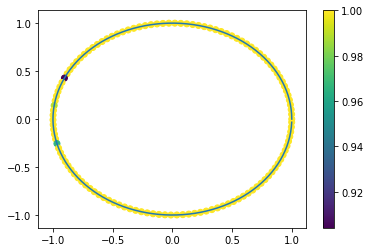

In [71]:
xs = np.array([t[0] for t in targets])
ys = np.array([t[1] for t in targets])
cs = np.array([float(f) for f in fidelities])
plt.plot(xs, ys)
# xs = xs[cs < 0.7]
# ys = ys[cs < 0.7]
# cs = cs[cs < 0.7]
plt.scatter(xs, ys, c=cs)
plt.colorbar()
# print('\n'.join([str(x) for x in list(zip(xs, ys))]))

In [72]:
replica_target = [min(zip(fidelities, targets), key=lambda x: x[0])[1]] * 20
replica_fidelities = batch_solve_tensorflow(dim, h_generator, source, critical_target)






  0%|          | 0/20 [00:00<?, ?it/s]




  5%|▌         | 1/20 [00:02<00:48,  2.55s/it]




 10%|█         | 2/20 [00:04<00:44,  2.48s/it]




 15%|█▌        | 3/20 [00:07<00:41,  2.45s/it]




 20%|██        | 4/20 [00:09<00:38,  2.41s/it]




 25%|██▌       | 5/20 [00:11<00:35,  2.39s/it]




 30%|███       | 6/20 [00:14<00:33,  2.39s/it]




 35%|███▌      | 7/20 [00:16<00:31,  2.39s/it]




 40%|████      | 8/20 [00:19<00:28,  2.38s/it]




 45%|████▌     | 9/20 [00:21<00:26,  2.37s/it]




 50%|█████     | 10/20 [00:23<00:23,  2.35s/it]




 55%|█████▌    | 11/20 [00:26<00:22,  2.48s/it]




 60%|██████    | 12/20 [00:29<00:20,  2.51s/it]




 65%|██████▌   | 13/20 [00:31<00:17,  2.51s/it]




 70%|███████   | 14/20 [00:34<00:15,  2.58s/it]




 75%|███████▌  | 15/20 [00:36<00:13,  2.61s/it]




 80%|████████  | 16/20 [00:39<00:10,  2.51s/it]




 85%|████████▌ | 17/20 [00:41<00:07,  2.43s/it]




 90%|█████████ | 18/20 [00:43<00:04,  2.38s/it]




 95%|█████████▌| 19/20 [0

In [73]:
replica_fidelities

[array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]])]